In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Auto Encoder

#### 3D sample data generate

In [10]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

### 1. undercomplete Linear Auto Encoder

In [11]:
# linear auto encoder ( = PCA)
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape = [3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape = [2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss = "mse", optimizer = keras.optimizers.SGD(lr = 0.1))

history = autoencoder.fit(X_train, X_train, epochs = 20)
codings = encoder.predict(X_train)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 0s 4ms/sample - loss: 0.3039
Epoch 2/20
60/60 [==============================] - 0s 66us/sample - loss: 0.2834
Epoch 3/20
60/60 [==============================] - 0s 66us/sample - loss: 0.2667
Epoch 4/20
60/60 [==============================] - 0s 100us/sample - loss: 0.2513
Epoch 5/20
60/60 [==============================] - 0s 84us/sample - loss: 0.2373
Epoch 6/20
60/60 [==============================] - 0s 83us/sample - loss: 0.2232
Epoch 7/20
60/60 [==============================] - 0s 116us/sample - loss: 0.2101
Epoch 8/20
60/60 [==============================] - 0s 83us/sample - loss: 0.1986
Epoch 9/20
60/60 [==============================] - 0s 100us/sample - loss: 0.1839
Epoch 10/20
60/60 [==============================] - 0s 83us/sample - loss: 0.1719
Epoch 11/20
60/60 [==============================] - 0s 83us/sample - loss: 0.1603
Epoch 12/20
60/60 [==============================] - 0s 117us/sample - los

### 2. stacked autoencoder

In [13]:
# fashion mnist
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# normalization
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [14]:
# 예측 출력이 0 ~ 1사이 실수인데, 이를 반올림하여 정확도 측도를 사용할 수 있다.
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

# 인코더 : 28*28를 받아 길이 30인 1d벡터 생성
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(30, activation = "selu")
])

# 디코더 : 길이 30인 1d 벡터를 받아 28*28 텐서 생성
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = "selu", input_shape = [30]),
    keras.layers.Dense(28 * 28, activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss = "binary_crossentropy",
                   optimizer = keras.optimizers.SGD(lr = 1.5),
                   metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs = 20,
                         validation_data = (X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 7s 127us/sample - loss: 0.3390 - rounded_accuracy: 0.8860 - val_loss: 0.3111 - val_rounded_accuracy: 0.9129
Epoch 2/20
55000/55000 [==============================] - 7s 122us/sample - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3047 - val_rounded_accuracy: 0.9200
Epoch 3/20
55000/55000 [==============================] - 7s 120us/sample - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.3035 - val_rounded_accuracy: 0.9117
Epoch 4/20
55000/55000 [==============================] - 6s 109us/sample - loss: 0.2950 - rounded_accuracy: 0.9246 - val_loss: 0.2944 - val_rounded_accuracy: 0.9278
Epoch 5/20
55000/55000 [==============================] - 6s 111us/sample - loss: 0.2924 - rounded_accuracy: 0.9268 - val_loss: 0.2924 - val_rounded_accuracy: 0.9274
Epoch 6/20
55000/55000 [==============================] - 6s 115us/sample - loss: 0.2908 - rounded_accuracy: 0.9281 - val

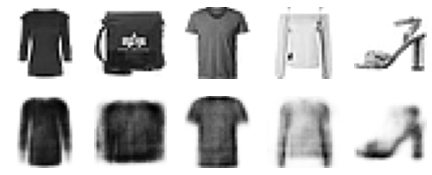

In [17]:
def plot_image(image):
    plt.imshow(image, cmap = 'binary')
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images]) # 입력 데이터를 재표현
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(stacked_ae)

### 3. demensionality reduction

In [23]:
y_valid

array([0, 8, 0, ..., 3, 0, 5], dtype=uint8)

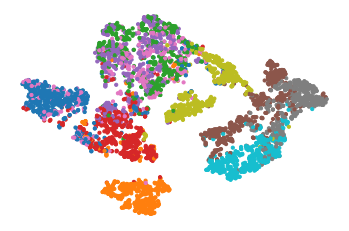

In [18]:
from sklearn.manifold import TSNE

# 30 -> 2
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

# scaling
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

### 4. Tying weights
인코더와 디코더가 완전 대칭 구조일 때, 인코더의 가중치를 transpose하여  
디코더의 가중치로써 사용할 수 있다.

In [26]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation = None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name = "bias",
                                      shape = [self.dense.input_shape[-1]],
                                      initializer = "zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b = True)
        return self.activation(z + self.biases)

In [28]:
dense_1 = keras.layers.Dense(100, activation = "selu")
dense_2 = keras.layers.Dense(30, activation = "selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation = "selu"),
    DenseTranspose(dense_1, activation = "sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss = "binary_crossentropy",
                optimizer = keras.optimizers.SGD(lr = 1.5), metrics = [rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs = 10,
                      validation_data = (X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 137us/sample - loss: 0.3264 - rounded_accuracy: 0.8966 - val_loss: 0.3016 - val_rounded_accuracy: 0.9207
Epoch 2/10
55000/55000 [==============================] - 7s 124us/sample - loss: 0.2968 - rounded_accuracy: 0.9232 - val_loss: 0.2967 - val_rounded_accuracy: 0.9276
Epoch 3/10
55000/55000 [==============================] - 7s 126us/sample - loss: 0.2911 - rounded_accuracy: 0.9286 - val_loss: 0.2971 - val_rounded_accuracy: 0.9274
Epoch 4/10
55000/55000 [==============================] - 7s 127us/sample - loss: 0.2882 - rounded_accuracy: 0.9311 - val_loss: 0.2891 - val_rounded_accuracy: 0.9334
Epoch 5/10
55000/55000 [==============================] - 6s 116us/sample - loss: 0.2861 - rounded_accuracy: 0.9329 - val_loss: 0.2862 - val_rounded_accuracy: 0.9345
Epoch 6/10
55000/55000 [==============================] - 7s 119us/sample - loss: 0.2848 - rounded_accuracy: 0.9341 - val

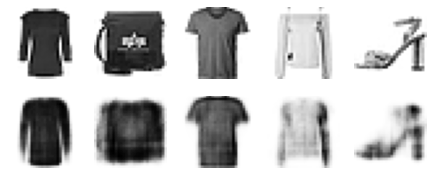

In [29]:
show_reconstructions(tied_ae)
plt.show()

절반의 파라미터로 이전 모델보다 더 낮은 재구성 오차 달성!!

### 5. convolutional autoencoder

In [30]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    # transposed convolution
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
# history = conv_ae.fit(X_train, X_train, epochs=5,
#                       validation_data=(X_valid, X_valid))

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

### 6. recurrent autoencoder

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30) # 마지막 은닉상태만 출력
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]), # 마지막 은닉상태를 28번 복사?
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])